# Assignment 2: Final Analysis of CitiBike Data
Team members: Kaylyn Levine, Nurvirta Monarizqa, Xueqi Huang

## Idea
Does the trip distance distribution of a CitiBike users vary with age?

**Define trip distance:** The distance in miles between start station and end station locations.

**Define age groups:**

* Y = young riders: y >= 1980 (millenials)

* X = total riders: 1951 > x < 1980  (working population, not typically retired)

**Define long distance trips:**

* L = trips > 3 miles from start to end station

* S = trips <= 3 miles from start to end station

## State Hypotheses:
### Null Hypothesis: 

The ratio of long distance trips by young riders to all distance trips by young riders is less than or equal to the ratio of long distance trips by the rest of the population to all distance trips by the rest of the population.

$$Ly/Sy-Lx/Sx<=0$$
### Alternative Hypothesis:

The ratio of long distance trips by young riders to all distance trips by young riders is greater than the ratio of long distance trips by the rest of the population to all distance trips by the rest of the population.

$$Ly/Sy-Lx/Sx>0$$
**Significance level:** 0.05

## Set up the work for data-driven inference based on CitiBike data.

In [1]:
# import packages
import os
import os.path
import seaborn as sns
import pylab as pl
import pandas as pd
import scipy.stats
import geopy # THIS PACKAGE DOES NOT COME WITH ANACONDA, INSTALL FIRST
from geopy.distance import vincenty
from zipfile import ZipFile
from StringIO import StringIO
import urllib2
import urllib
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# check if there exists 'PUIDATA'
if os.getenv('PUIDATA') is None:
    path = os.getcwd()
else:
    path = os.getenv('PUIDATA')

# check if the file exists. If not, download from the internet
filename = '201606-citibike-tripdata.zip'
fullfilename = os.path.join(path, filename)
if os.path.isfile(fullfilename) == True:
    pass
else:
    urllib.urlretrieve('https://s3.amazonaws.com/tripdata/201606-citibike-tripdata.zip', fullfilename)
    
# open the data
z = ZipFile(fullfilename)
citibikedata = z.open('201606-citibike-tripdata.csv')
data = pd.read_csv(citibikedata)
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1470,6/1/2016 00:00:18,6/1/2016 00:24:48,380,W 4 St & 7 Ave S,40.734011,-74.002939,3236,W 42 St & Dyer Ave,40.758985,-73.993800,19859,Subscriber,1972.0,1
1,229,6/1/2016 00:00:20,6/1/2016 00:04:09,3092,Berry St & N 8 St,40.719009,-73.958525,3103,N 11 St & Wythe Ave,40.721533,-73.957824,16233,Subscriber,1967.0,1
2,344,6/1/2016 00:00:21,6/1/2016 00:06:06,449,W 52 St & 9 Ave,40.764618,-73.987895,469,Broadway & W 53 St,40.763441,-73.982681,22397,Subscriber,1989.0,1
3,1120,6/1/2016 00:00:28,6/1/2016 00:19:09,522,E 51 St & Lexington Ave,40.757148,-73.972078,401,Allen St & Rivington St,40.720196,-73.989978,16231,Subscriber,1991.0,1
4,229,6/1/2016 00:00:53,6/1/2016 00:04:42,335,Washington Pl & Broadway,40.729039,-73.994046,285,Broadway & E 14 St,40.734546,-73.990741,15400,Subscriber,1989.0,1


In [3]:
#explore data: statistics
#this reveals that the majority of the data lies near our interest: millenials
datamean = data["birth year"].mean()
datamedian = data["birth year"].median()
print(datamean)
print(datamedian)

1977.6594183
1980.0


In [4]:
# remove unneeded data before proceeding with analysis
# this will allow the script to run faster
data = data.loc[:,["start station latitude","start station longitude","end station latitude", "end station longitude", "birth year" ]]
data.head()

,start station latitude,start station longitude,end station latitude,end station longitude,birth year
0,40.734011,-74.002939,40.758985,-73.993800,1972.0
1,40.719009,-73.958525,40.721533,-73.957824,1967.0
2,40.764618,-73.987895,40.763441,-73.982681,1989.0
3,40.757148,-73.972078,40.720196,-73.989978,1991.0
4,40.729039,-73.994046,40.734546,-73.990741,1989.0


In [5]:
#add new columns to begin calculating distance using decimal degrees
#distance = (latitude, longitude of end station) subtracted from (latitude, longitude of start station)
data.loc[:,"start_location"] = "(" + data["start station latitude"].map(str) + "," + " " + data["start station longitude"].map(str) + ")"
data.loc[:,"stop_location"] = "(" + data["end station latitude"].map(str) + "," + " " + data["end station longitude"].map(str) + ")"
data.loc[:,"start_location"] = data.loc[:,"start_location"].map(eval)
data.loc[:,"stop_location"] = data.loc[:,"stop_location"].map(eval)
data.head()

,start station latitude,start station longitude,end station latitude,end station longitude,birth year,start_location,stop_location
0,40.734011,-74.002939,40.758985,-73.993800,1972.0,"(40.73401143, -74.00293877)","(40.758984814, -73.9937996864)"
1,40.719009,-73.958525,40.721533,-73.957824,1967.0,"(40.7190095, -73.95852515)","(40.72153267, -73.95782357)"
2,40.764618,-73.987895,40.763441,-73.982681,1989.0,"(40.76461837, -73.98789473)","(40.76344058, -73.98268129)"
3,40.757148,-73.972078,40.720196,-73.989978,1991.0,"(40.75714758, -73.97207836)","(40.72019576, -73.98997825)"
4,40.729039,-73.994046,40.734546,-73.990741,1989.0,"(40.72903917, -73.99404649)","(40.73454567, -73.99074142)"


In [6]:
# eliminate data entries that fall outside of our scope (born after 1951)
newdata = data[data["birth year"] > 1951]
len(newdata)

1240530

## find distance from decimal degree data using geopy

In [7]:
#create new distance column and populate it
#first define a function that uses vincenty (from geopy) to find distance in miles

def dist_newdata(df):
    '''
    function to return start and stop locations in miles for all rows
    
    output will be used to calculate trip distance
    
    '''
    return vincenty(df["start_location"],df["stop_location"]).miles

#create new column titled 'distance' and run the function
#BE ADVISED: THIS MAY TAKE UP TO 10 MINUTES TO RUN COMPLETELY

newdata["distance"] = newdata.apply(dist_newdata, axis=1)

#check to see if the function worked properly
newdata.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,start station latitude,start station longitude,end station latitude,end station longitude,birth year,start_location,stop_location,distance
0,40.734011,-74.002939,40.758985,-73.993800,1972.0,"(40.73401143, -74.00293877)","(40.758984814, -73.9937996864)",1.788728
1,40.719009,-73.958525,40.721533,-73.957824,1967.0,"(40.7190095, -73.95852515)","(40.72153267, -73.95782357)",0.177958
2,40.764618,-73.987895,40.763441,-73.982681,1989.0,"(40.76461837, -73.98789473)","(40.76344058, -73.98268129)",0.285343
3,40.757148,-73.972078,40.720196,-73.989978,1991.0,"(40.75714758, -73.97207836)","(40.72019576, -73.98997825)",2.717342
4,40.729039,-73.994046,40.734546,-73.990741,1989.0,"(40.72903917, -73.99404649)","(40.73454567, -73.99074142)",0.417694


In [8]:
#explore new data column
distance_mean = newdata["distance"].mean()
print(distance_mean)

1.16313687622


In [9]:
#visualize data, distance less than 20 miles
#this was used as a cutoff for extraneous values that would affect our analysis
data_cut = newdata[newdata["distance"] < 20].copy()

#add status
def mil(df):
    if df['birth year'] < 1980:
        return 'non-millennials'
    else:
        return 'millennials' 

data_cut['status'] = data_cut.apply(mil, axis=1)

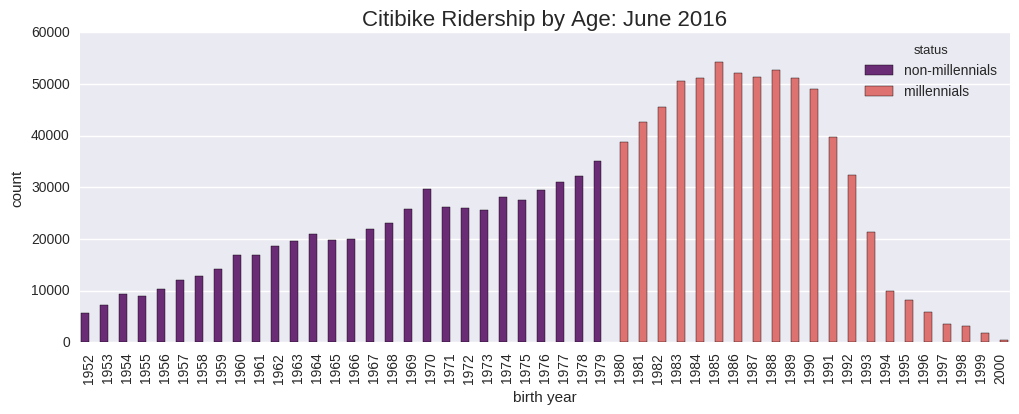

In [10]:
#then, plot birth year versus distance for exploration
birthyear = data_cut['birth year'].unique().astype(int)
birthyear.sort()
sns.set(font_scale=1) 
plt.figure(figsize=(12,4))
g = sns.countplot(x='birth year',data=data_cut,hue='status',palette='magma')
g.set_xticklabels(birthyear,rotation=90)
plt.title('Citibike Ridership by Age: June 2016', fontsize=16)
plt.show()


In [11]:
#create new dataset of just 'long distance' trips greater than 3 miles from start to end station
data_3 = data_cut[data_cut["distance"] >3].copy()

#group data by birth year of just data_3 dataset to see count distribution for long distance trips
count_per_birth_year_long = data_3["distance"].groupby(data_3["birth year"]).count()

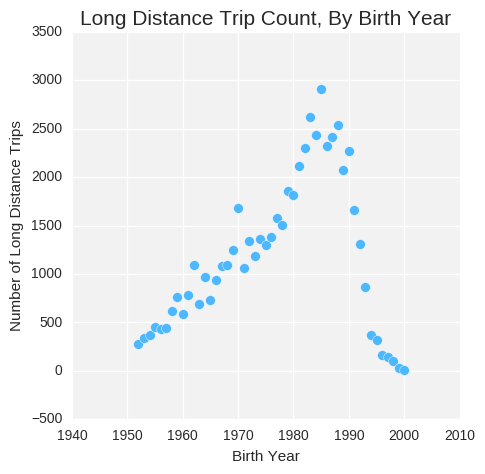

In [12]:
#plot trip counts per birth year
fig = pl.figure(figsize(5,5))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#f2f2f2')
pl.scatter(count_per_birth_year_long.index, count_per_birth_year_long.values, s=50, facecolors='#4db8ff', edgecolors='white')
pl.ylabel('Number of Long Distance Trips')
pl.xlabel('Birth Year')
pl.title("Long Distance Trip Count, By Birth Year", size=15)

In [13]:
#group data by birth year, all trips 
count_per_birth_year_all = data_cut["distance"].groupby(data_cut["birth year"]).count()

#normalize data for long trip analysis
count_per_birth_normalized = count_per_birth_year_long / count_per_birth_year_all

#create a dataframe to collect the information
df = pd.DataFrame({'total':count_per_birth_year_all,
                  'long trip':count_per_birth_year_long,
                  'ratio long trip': count_per_birth_normalized})

#create status column
df['status'] = ''
df.loc[:1979,:]['status'] = 'non-millennials'
df.loc[1980:,:]['status'] = 'millennials'

#put birth year outside the index
df['birth year'] = df.index.astype(int)

df.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,long trip,ratio long trip,total,status,birth year
birth year,,,,,
1952.0,280,0.048934,5722,non-millennials,1952
1953.0,337,0.046451,7255,non-millennials,1953
1954.0,366,0.038845,9422,non-millennials,1954
1955.0,449,0.050179,8948,non-millennials,1955
1956.0,436,0.042219,10327,non-millennials,1956


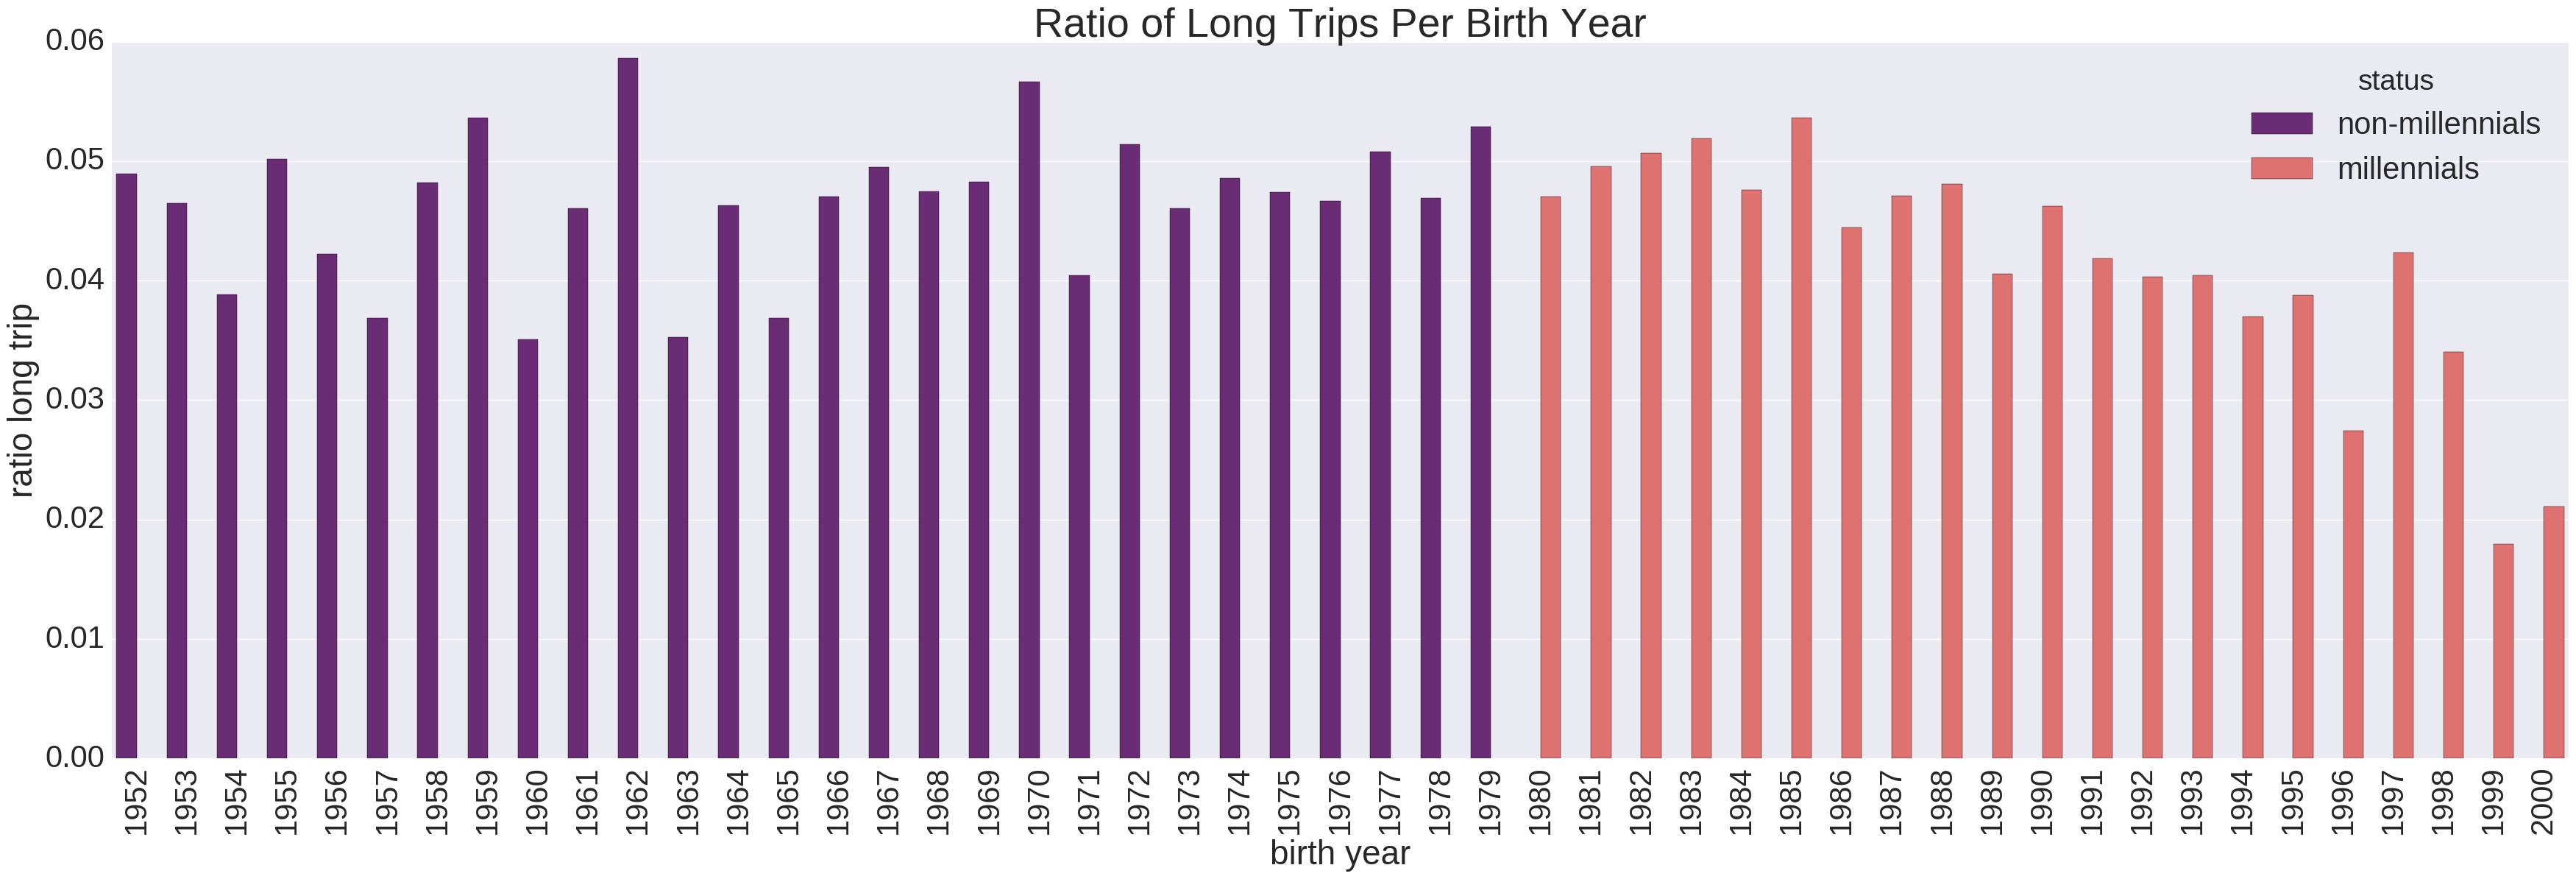

In [14]:
# plot the normalized data
sns.set(font_scale=3) 
f = sns.factorplot(x='birth year',y='ratio long trip',data=df,hue='status',palette='magma',kind='bar',size=12,aspect =3,
                   legend_out=False)
f.set_xticklabels(birthyear,rotation=90)
plt.title('Ratio of Long Trips Per Birth Year', fontsize=40)
plt.show()

## Analysis: Ratio Distributions and Z Test

### This is the beginning of Assignment 6, after receiving peer feedback

In [15]:
# create variables for each variable for hypothesis testing

allriders_long = count_per_birth_year_long
allriders_all = count_per_birth_year_all

youngriders_long = allriders_long[allriders_long.index>=1980]
youngriders_all = allriders_all[allriders_all.index>=1980]


# ratio for young riders
young_ratio = youngriders_long / youngriders_all

# ration for all riders
all_ratio = allriders_long / allriders_all

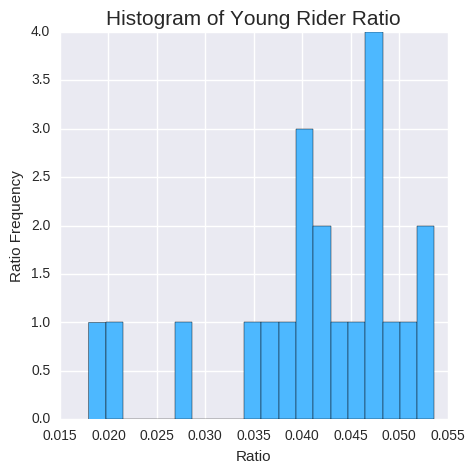

In [16]:
# plot histogram of young rider ratio to explore distribution
sns.set(font_scale=1) 
fig = pl.figure(figsize(5,5))
young_hist = pl.hist(young_ratio, bins=20, facecolor='#4db8ff')
pl.ylabel('Ratio Frequency')
pl.xlabel('Ratio')
pl.title("Histogram of Young Rider Ratio", size=15)

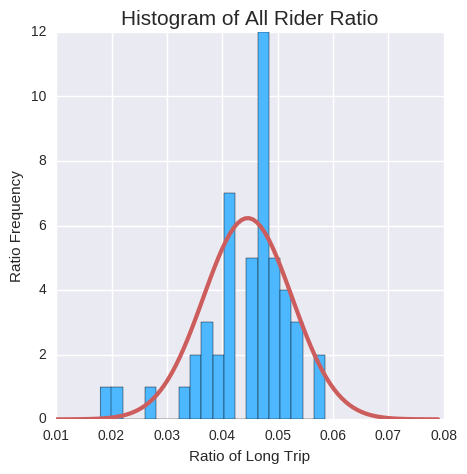

In [17]:
sns.set(font_scale=1) 
fig = pl.figure(figsize(5,5))
plt.hist(df['ratio long trip'],bins = 20,facecolor='#4db8ff')
lnspc = np.linspace(0.01, 0.079, 100)
pdf_g = scipy.stats.norm.pdf(lnspc, 0.0446,0.008)/8
pl.title("Histogram of All Rider Ratio", size=15)
plt.xlabel('Ratio of Long Trip')
pl.ylabel('Ratio Frequency')
plt.plot(lnspc, pdf_g,color='IndianRed', lw=3)

### Perform Z Test:

In [18]:
# find means for z test
young_mean = young_ratio.mean()
all_mean = all_ratio.mean()

# find standard deviations for z test
young_std = young_ratio.std()
all_std = all_ratio.std()

Z = (young_mean - all_mean) / (young_std / np.sqrt(len(young_ratio)))
print Z

-1.42813406171


In [19]:
alpha = .05
print("Z score for our analysis of young riders who take long trips: {0:.1f}".format(Z))
print("This means we are {0:.1f} standard deviations away".format(Z))
print("from the mean of all the CitiBike riders who take long trips\n\n")
if Z < -2:
    result = "IS REJECTED"
else: 
    result = "CANNOT BE REJECTED"

print("The Null Hypothesis that the new route does not improve commuting")
print("{0:s} at the {1:.1f}% significance level".format(result, 100*(1-alpha)))

Z score for our analysis of young riders who take long trips: -1.4
This means we are -1.4 standard deviations away
from the mean of all the CitiBike riders who take long trips


The Null Hypothesis that the new route does not improve commuting
CANNOT BE REJECTED at the 95.0% significance level


In [20]:
# find p-value and make hypothesis conclusions
pvalue = (1 - scipy.stats.norm.cdf(Z))
print pvalue

0.92337336242


### Z Test Results:

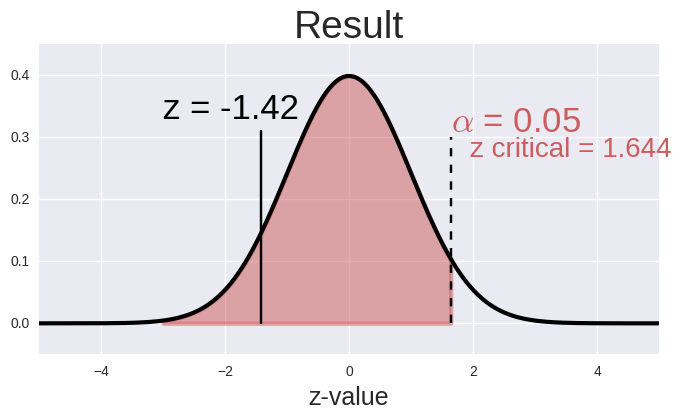

In [27]:
# visualize the result

x = np.arange(-5,5,0.01)
z_critical = -scipy.stats.norm.ppf(0.05)
gs = lambda x: np.exp((-(x)**2)/2)*1.0/np.sqrt(2*np.pi)

fig = plt.figure(4,figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(x,gs(x),color='black',lw=3)

fill_area = np.arange(-3,z_critical,.01)

ax.fill_between(fill_area,np.zeros(len(fill_area)),gs(fill_area),color='IndianRed', 
                                alpha=0.5,lw=3,label=r'1$\sigma$ = 16\%')
ax.set_xlabel("z-value",fontsize = 18)
ax.plot([z_critical, z_critical], [0, 0.30], '--k')
ax.plot([-1.42, -1.42], [0, 0.31], 'k')
                
#pl.legend()
ax.set_ylim(-0.05,0.45)
ax.set_xlim(-5,5)
plt.text(z_critical,0.31,r'$\alpha$ = 0.05', color='IndianRed', size=25)
plt.text(1.95,0.27,r'z critical = 1.644', color='IndianRed', size=20)
plt.text(-3,0.33,r'z = -1.42', color='k', size=25)
plt.title('Result', fontsize = 28)
plt.show()

The p-value allows us to interpret our results in terms of the probability to reject the null hypothesis. Our Z score (-1.4) is less than our p-value (1.96) so we cannot reject the null hypothesis at a 95% significance level.

According to this analysis of the CitiBike data, the ratio of long distance trips for young riders is not greater than the ratio of long distance trips for all riders.